# Konfigurasi Awal
Bagian konfigurasi awal untuk mendapatkan file input,
## Download from google cloud storage
Semua file input maupun output disimpan di cloud storage
### Nama file
file input: data/input-latest.csv
file output: data/output-latest.json
> Boleh juga jika modelnya ingin diexport
#### File input dikoleksi setiap hari dengan format input-timestamp.csv

In [1]:
import os

In [2]:
import sys
!{sys.executable} -m pip install python-dotenv

In [3]:
from dotenv import load_dotenv

load_dotenv()
os.environ["TFVERSION"] = "2.3"
os.environ["PYTHONVERSION"] = "3.7"

In [4]:
%%bash

mkdir -p data
gsutil -q -m cp gs://$BUCKET_NAME/data/input* data/

### Kode Machine Learning
> Masukan Kode ML dari cell ini

In [1]:
import tensorflow as tf

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None, label=''):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.title(label)

In [3]:
!wget --no-check-certificate --quiet \
    'https://docs.google.com/uc?export=download&id=16--Ajvpw80UYpav_g35EOlZRR2_d6W7B' \
      -O data/sales_data_sample.csv

In [4]:
data = pd.read_csv('data/sales_data_sample.csv', encoding='Latin-1', sep=';')
data.head()

,id,name,visitor,interest,place_id,contact
0,1,RUMAH PRODUKSI BUMBU UMAY,240,2,ChIJSbe7edeRei4RNsJWmGkQBPI,6.280000e+12
1,1,RUMAH PRODUKSI BUMBU UMAY,272,5,ChIJSbe7edeRei4RNsJWmGkQBPI,6.280000e+12
2,1,RUMAH PRODUKSI BUMBU UMAY,328,2,ChIJSbe7edeRei4RNsJWmGkQBPI,6.280000e+12
3,1,RUMAH PRODUKSI BUMBU UMAY,360,6,ChIJSbe7edeRei4RNsJWmGkQBPI,6.280000e+12
4,1,RUMAH PRODUKSI BUMBU UMAY,392,14,ChIJSbe7edeRei4RNsJWmGkQBPI,6.280000e+12


In [5]:
list = data['name'].tolist()
place = []
for i in list:
  if i in place:
    pass
  else:
    place.append(i)
place

['RUMAH PRODUKSI BUMBU UMAY',
 'Sirup Jahe Dewa',
 'Sambal Mbak Ririn',
 'Sambal Pawon Soendari Magelang',
 'Getuk Eco',
 'Furnistic Woodworking - Custom Furniture dan Craft Kayu Magelang',
 "Coklat Bar dan Karakter Magelang De'Imutz Choco",
 'Kebon Ndoro',
 'Sambal Lidah Mertua',
 'RACIK SEWU produsen jahe instan',
 'Encah Cake & Bakery',
 'BHF (Borobudur Home Furniture)']

In [6]:
def prepare_data(nama):
  prep_data = data[data['name'] == nama]
  prep_series = prep_data['visitor'].to_numpy(dtype='float64')
  prep_steps = np.arange(len(prep_data), dtype='float64')
  return prep_series, prep_steps

series = data['visitor'].to_numpy(dtype='float64')
time = np.arange(len(data), dtype='float64')

series_umay, steps_umay = prepare_data(place[0])
series_sirup, steps_sirup = prepare_data(place[1])
series_sambal, steps_sambal = prepare_data(place[2])
series_pawon, steps_pawon = prepare_data(place[3])
series_eco, steps_eco = prepare_data(place[4])
series_wood, steps_wood = prepare_data(place[5])
series_choco, steps_choco = prepare_data(place[6])
series_ndoro, steps_ndoro = prepare_data(place[7])
series_lidah, steps_lidah = prepare_data(place[8])
series_jahe, steps_jahe = prepare_data(place[9])
series_cake, steps_cake = prepare_data(place[10])
series_bhf, steps_bhf = prepare_data(place[11])

"""
plt.show(plot_series(steps_umay, series_umay, label='Data toko UMAY'))
plt.show(plot_series(steps_sirup, series_sirup, label='Data toko Sirup jahe Dewa'))
plt.show(plot_series(steps_sambal, series_sambal, label='Data toko Sambal Mbak Ririn'))
plt.show(plot_series(steps_pawon, series_pawon, label='Data toko Sambal Pawon Soendari Magelang'))
plt.show(plot_series(steps_eco, series_eco, label='Data toko Getuk Eco'))
plt.show(plot_series(steps_wood, series_wood, label='Data toko Furnistic Woodworking - Custom Furniture dan Craft Kayu Magelang'))
plt.show(plot_series(steps_choco, series_choco, label='Data toko ' + place[6]))
plt.show(plot_series(steps_ndoro, series_ndoro, label='Data toko ' + place[7]))
plt.show(plot_series(steps_lidah, series_lidah, label='Data toko ' + place[8]))
plt.show(plot_series(steps_jahe, series_jahe, label='Data toko ' + place[9]))
plt.show(plot_series(steps_cake, series_cake, label='Data toko ' + place[10]))
plt.show(plot_series(steps_bhf, series_bhf, label='Data toko ' + place[11]))
"""

"\nplt.show(plot_series(steps_umay, series_umay, label='Data toko UMAY'))\nplt.show(plot_series(steps_sirup, series_sirup, label='Data toko Sirup jahe Dewa'))\nplt.show(plot_series(steps_sambal, series_sambal, label='Data toko Sambal Mbak Ririn'))\nplt.show(plot_series(steps_pawon, series_pawon, label='Data toko Sambal Pawon Soendari Magelang'))\nplt.show(plot_series(steps_eco, series_eco, label='Data toko Getuk Eco'))\nplt.show(plot_series(steps_wood, series_wood, label='Data toko Furnistic Woodworking - Custom Furniture dan Craft Kayu Magelang'))\nplt.show(plot_series(steps_choco, series_choco, label='Data toko ' + place[6]))\nplt.show(plot_series(steps_ndoro, series_ndoro, label='Data toko ' + place[7]))\nplt.show(plot_series(steps_lidah, series_lidah, label='Data toko ' + place[8]))\nplt.show(plot_series(steps_jahe, series_jahe, label='Data toko ' + place[9]))\nplt.show(plot_series(steps_cake, series_cake, label='Data toko ' + place[10]))\nplt.show(plot_series(steps_bhf, series_bhf

In [27]:
split_time = 2700
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 100
batch_size = 16
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size=10):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast
    
def plot_forecast(series):
    rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
    rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
    return plt.figure(figsize=(10, 6)), plot_series(time_valid, x_valid), plot_series(time_valid, rnn_forecast)

def forecast_new(series, Toko, ID, steps=1):
    #forecast
    _based_series = series[-window_size:]
    results = []
    for i in range(steps):
        _based_series = _based_series[-window_size:]
        _r = model_forecast(model, _based_series.reshape(-1,1),window_size)[-1,-1]
        results.append(_r[0])
        _based_series = np.append(_based_series,_r)
    results = np.array(results)
    js = results.tolist()
    rn = {
        'Toko' : name,
        'ID' : placeid,
        'forecast' : js
    }
    json_str = json.dumps(rn)
    return json_str

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]), 
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 500)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)


Epoch 1/500
163/163 [==============================] - 27s 167ms/step - loss: 69.2738 - mae: 69.7725
Epoch 2/500
163/163 [==============================] - 25s 156ms/step - loss: 65.1438 - mae: 65.6424
Epoch 3/500
163/163 [==============================] - 26s 158ms/step - loss: 64.9800 - mae: 65.4786
Epoch 4/500
163/163 [==============================] - 25s 152ms/step - loss: 64.8496 - mae: 65.3481
Epoch 5/500
163/163 [==============================] - 26s 160ms/step - loss: 64.7299 - mae: 65.2285
Epoch 6/500
163/163 [==============================] - 23s 140ms/step - loss: 64.6521 - mae: 65.1506
Epoch 7/500
163/163 [==============================] - 25s 156ms/step - loss: 64.3775 - mae: 64.8762
Epoch 8/500
163/163 [==============================] - 24s 146ms/step - loss: 64.1943 - mae: 64.6930
Epoch 9/500
163/163 [==============================] - 27s 167ms/step - loss: 63.9998 - mae: 64.4982
Epoch 10/500
163/163 [==============================] - 28s 169ms/step - loss: 63.8285 - ma

(<Figure size 720x432 with 1 Axes>, None, None)

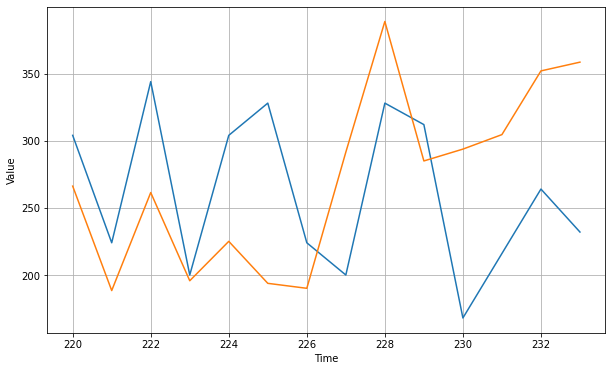

In [24]:
plot_umay = plot_forecast(series_umay)
plot_umay

In [34]:
forecast_umay = forecast_new(series_umay, Toko='Oleh-oleh ECO', ID=1, steps=30)
print(forecast_umay)
with open("data/output-latest.json", "w") as file:
    file.write(forecast_umay)

{"Toko": "Oleh-oleh ECO", "ID": 1, "forecast": [483.418212890625, 417.62982177734375, 411.1540832519531, 352.4342041015625, 288.5237731933594, 279.8297424316406, 231.8590087890625, 270.0309143066406, 212.23435974121094, 284.32940673828125, 207.37481689453125, 274.07183837890625, 191.59481811523438, 222.59719848632812, 208.12364196777344, 417.1957092285156, 350.62347412109375, 294.8687438964844, 172.38153076171875, 267.0450439453125, 301.0193786621094, 231.62217712402344, 350.9587707519531, 183.8987274169922, 211.66058349609375, 170.75338745117188, 457.1097717285156, 377.54730224609375, 405.5428466796875, 340.9356994628906]}


### Upload file output
File output diupload ke cloud storage

#### Format file output: 
`output-latest.json` dan `output-[timestamp].json`, boleh juga kalau mau upload bentuk lainnya (misal HDF5 nya dll.)
> Pastikan output **disimpan ke direktori data**

In [50]:
%%bash

gsutil -q cp data/output* gs://$BUCKET_NAME/data/